In [44]:
%matplotlib inline
import sklearn
from sklearn import manifold
from sklearn import datasets
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.extmath import safe_sparse_dot
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.metrics import pairwise_distances_argmin
import math
import pandas as pd
import random
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import os
pd.__version__
matplotlib.__version__
np.__version__
sklearn.__version__

'0.23.2'

In [45]:
parentDir = "results"
if not os.path.exists(parentDir):
    os.mkdir(parentDir)

In [46]:
X_example, Y_example = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
print(X_example[:10])
print(Y_example[:10])

[[ 0.83685684  2.13635938]
 [-1.4136581   7.40962324]
 [ 1.15521298  5.09961887]
 [-1.01861632  7.81491465]
 [ 1.27135141  1.89254207]
 [ 3.43761754  0.26165417]
 [-1.80822253  1.59701749]
 [ 1.41372442  4.38117707]
 [-0.20493217  8.43209665]
 [-0.71109961  8.66043846]]
[1 3 0 3 1 1 2 0 3 3]


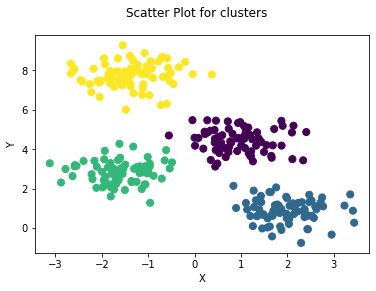

In [47]:
df = pd.DataFrame({"x": X_example[:,0], "y": X_example[:,1], "label": Y_example})
df.to_csv(parentDir + "/blob_data_init.csv", sep="\t", encoding="utf-8")

fig = plt.figure()
fig.suptitle('Scatter Plot for clusters')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.scatter(X_example[:,0],X_example[:,1], c=Y_example, s=50, cmap='viridis')

In [48]:
def get_inertia(vectors_of_all_centroids, data, labels, distance_function):
    totaldistance = 0
    for a in range(len(data)):
        localdistance = distance_function(data[a], vectors_of_all_centroids[labels[a]])
        totaldistance += localdistance
    return totaldistance

In [49]:
def custom_pairwise_distances_argmin(data, centroids, tolerance, distance_function):
    resultIndices = []
    for aIndex in range(len(data)):
        currentMinDistance = round(distance_function(data[aIndex],centroids[0]),tolerance)
        currentMinDistanceIndex = 0
        for bIndex in range(len(centroids)):
            distance = round(distance_function(data[aIndex],centroids[bIndex]),tolerance)
            if(distance < currentMinDistance):
                currentMinDistance = distance
                currentMinDistanceIndex = bIndex
        resultIndices.append(currentMinDistanceIndex)
    return resultIndices

In [50]:
def euclidean_distance(vector_0, vector_1):
    total = 0
    diff = 0
    for a in range(len(vector_0)):
        diff = vector_1[a] - vector_0[a]
        total = total + diff * diff
    return math.sqrt(total)

In [51]:
def custom_mean(vectors):
    dimensions = len(vectors[0])
    vector_elements = len(vectors)
    aggregate_vector = [0 for a in range(dimensions)]
    for a in range(vector_elements):
        for b in range(dimensions):
            aggregate_vector[b] += vectors[a][b]
    return [1.0 * a / vector_elements for a in aggregate_vector]

In [52]:
def generateRandomIndices(clusterNumber, minValue, maxValue):
    randomIndices = []
    indexDatapointWhichCentroidWillUse = -1;
    bias = 0;
    for a in range(0,clusterNumber):
        while(True):
            indexDatapointWhichCentroidWillUse = random.randint(minValue, maxValue-1)
            if(indexDatapointWhichCentroidWillUse not in randomIndices):
                break;
        randomIndices.append(indexDatapointWhichCentroidWillUse)
    return randomIndices

In [53]:
def arraysEqual(arr0, arr1, tolerance):
    lenArrAxis0 = len(arr0)
    lenArrAxis1 = len(arr1[0])
    for a in range(0, lenArrAxis0):
        for b in range(0, lenArrAxis1):
            if(round(arr0[a][b], tolerance) != round(arr1[a][b], tolerance)):
                return False
    return True

In [54]:
def calc_kmeans(data, n_clusters, tolerance, distance_function):
    if(len(data) < n_clusters):
        print("cannot request more cluster than data-points you have.")
        return
    random.seed(8)
    randomIndices = generateRandomIndices(n_clusters, 0, len(data))
    print(randomIndices)
    centroids = [data[x] for x in randomIndices]
    iterations = 0
    labels = []
    while True:
        iterations+=1
        labels = custom_pairwise_distances_argmin(data, centroids, tolerance, distance_function)
        new_centers = []
        for i in range(n_clusters):
            i_center_datapoints_indices = [a for a in labels if a ==i]
            if(len(i_center_datapoints_indices) == 0):
                new_centers.append(centroids[i])
            else:
                i_center_datapoints = data[i_center_datapoints_indices]
                i_center = custom_mean(i_center_datapoints)
                new_centers.append(i_center)
        if (arraysEqual(centroids, new_centers, tolerance)): #np.all(centroids == np_new_centers): # np.allclose(centroids, np_new_centers, rtol=0, atol=pow(0.1, tolerance)): #
            break
        centroids = new_centers
    return np.array(labels), np.array(centroids), get_inertia(centroids,data, labels, distance_function), iterations, n_clusters

[116, 189, 192, 64]


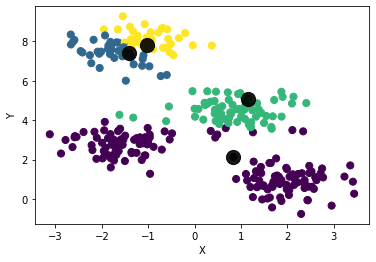

In [91]:
clusterNumber = 4
kmeans_result = calc_kmeans(X_example, clusterNumber, 2, euclidean_distance)

# print to csv
label_indices_init = np.where(kmeans_result[0] == 0)
df = pd.DataFrame({"cluster_0_x": X_example[label_indices_init][:,0], "cluster_0_y": X_example[label_indices_init][:,1], "cluster_0_label": 0})
for a in range(1, clusterNumber):
    label_indices = np.where(kmeans_result[0] == a)
    cluster_a_x_tmp = X_example[label_indices][:,0]
    cluster_a_y_tmp = X_example[label_indices][:,1]
    df = df.join(pd.DataFrame({"cluster_" + str(a) + "_x": cluster_a_x_tmp, "cluster_" + str(a) + "_y": cluster_a_y_tmp, "cluster_" + str(a) + "_label": a}))
df = df.join(pd.DataFrame({"centroid_x": kmeans_result[1][:,0],"centroid_y": kmeans_result[1][:,1]}))
df.to_csv(parentDir + "/blob_data_result.csv", sep=",", encoding="utf-8")

# create inline overview
fig = plt.figure()
# fig.suptitle('Scatter Plot for clusters')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')

label_indices_cluster_1 = np.where(kmeans_result[0] != 5) # np.where(np.logical_or(kmeans_result[0] == 1,kmeans_result[0] == 2))
    
ax.scatter(X_example[label_indices_cluster_1][:,0],X_example[label_indices_cluster_1][:,1], c=kmeans_result[0][label_indices_cluster_1], s=50, cmap='viridis')
ax.scatter(kmeans_result[1][:,0],kmeans_result[1][:,1], c='black', s=200, alpha=0.9)
plt.savefig('initialise_problem.pdf')